# Prepare azimuth offset for co-seismic deformation

```bash
# Sentinel-1 asc. track 99, May 20 - 26, 2021
cuDenseOffsets.py ... --ww 1024 --wh 512 --oo 128 --kw 48 --kh 14 --sw 8 --sh 8 --raw-osf 2 --redo --outprefix offset5

# Sentinel-1 desc. track 106, May 20 - 26, 2021
cuDenseOffsets.py ... --ww 1024 --wh 512 --oo 64  --kw 50 --kh 15 --sw 8 --sh 8 --raw-osf 2 --redo --outprefix offset2
```

In [1]:
%matplotlib inline
import os
import numpy as np
from matplotlib import pyplot as plt
from scipy import ndimage
from mintpy.objects import deramp
from mintpy.utils import readfile, writefile, plot as pp, isce_utils, utils as ut, attribute as attr
from mintpy import view, geocode, spatial_filter
from tools.offset_mask_filter import fill_offset_rubber_sheeting
plt.rcParams.update({'font.size': 12})

# file for azimuth offset [lowe resolution due to large window size to suppress noise]
off_file = os.path.expanduser('~/data/archives/2021MaduoEQ/SenAT099/merged/offsets/20210520_20210526/offset5.bip')  # asc.
#off_file = os.path.expanduser('~/data/archives/2021MaduoEQ/SenDT106/merged/offsets/20210520_20210526/offset2.bip')  # desc.

SNWE = (33.2, 35.9, 96.6, 100.1)  # output bounding box in lat/lon

# directory
proj_dir = os.path.abspath(os.path.join(off_file, '../../../..'))
geom_dir = os.path.join(os.path.dirname(off_file), 'geom{}'.format(off_file[-5]))
# work directory
work_dir = os.path.dirname(off_file)
os.chdir(work_dir)
print('Go to directory:', work_dir)

# aux files
fbase = os.path.splitext(off_file)[0]
cov_file = fbase + '_cov.bip'
snr_file = fbase + '_snr.bip'
lat_file = os.path.join(geom_dir, 'lat.rdr')
lon_file = os.path.join(geom_dir, 'lon.rdr')
los_file = os.path.join(geom_dir, 'los.rdr')
msk_file = os.path.join(geom_dir, 'waterMask.rdr')
dem_file = os.path.join(proj_dir, '../DEM/demLat_N33_N36_Lon_E096_E101.dem')

Go to directory: /Users/yunjunz/data/archives/2021MaduoEQ/SenAT099/merged/offsets/20210520_20210526


## 1. Mask offset

delete exsited file: azOff.h5
create HDF5 file: azOff.h5 with w mode
create dataset /offset of float32    in size of (1440, 1404)         with compression=None
finished writing to azOff.h5
ascending orbit -> flip up-down
ascending orbit -> flip up-down


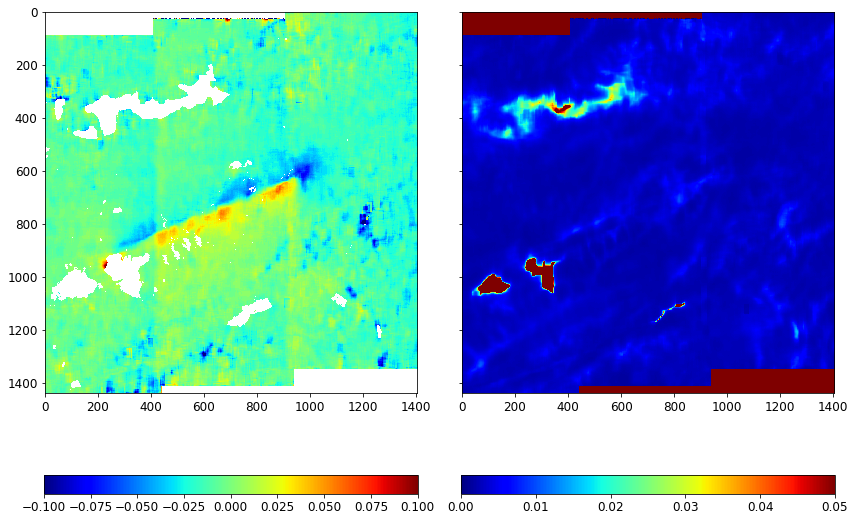

In [2]:
off, atr = readfile.read(off_file, datasetName='azimuthOffset')
length, width = int(atr['LENGTH']), int(atr['WIDTH'])

# pre-processing: water mask, valid mask from SNR and/or mask based on STD
water_mask = readfile.read(msk_file)[0]
off_snr = readfile.read(snr_file)[0]
off_std = np.sqrt(readfile.read(cov_file, datasetName='azimuthOffsetVar')[0])

# mask out invalid pixels
off[water_mask==0] = np.nan
off[np.isnan(off_snr)] = np.nan
off[off_std > 0.01] = np.nan

# write HDF5 file
az_off_file = 'azOff.h5'
atr['FILE_TYPE'] = 'offset'
atr['UNIT'] = 'pixel'
atr['ORBIT_DIRECTION'] = 'ascending' if 'SenA' in off_file else 'descending'
writefile.write(off, out_file=az_off_file, metadata=atr)

# plot
kwargs = dict(cmap='jet', interpolation='nearest')
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=[12, 8], sharey=True)
im = axs[0].imshow(off, vmin=-0.1, vmax=0.1,  **kwargs); fig.colorbar(im, ax=axs[0], orientation='horizontal')
im = axs[1].imshow(off_std, vmin=0, vmax=0.05, **kwargs); fig.colorbar(im, ax=axs[1], orientation='horizontal')
for ax in axs:
    pp.auto_flip_direction(atr, ax)
fig.tight_layout()
plt.show()

## 2. Correct for SAR proceesing effects manually

### 2.1 Get mask of the 3 sub-swaths

Run `view.py azOff.h5 --noflip` to grab the bounding box in Y/X for each sub-swath.

delete exsited file: maskIW1.h5
create HDF5 file: maskIW1.h5 with w mode
create dataset /mask of bool       in size of (1440, 1404)         with compression=None
finished writing to maskIW1.h5
delete exsited file: maskIW2.h5
create HDF5 file: maskIW2.h5 with w mode
create dataset /mask of bool       in size of (1440, 1404)         with compression=None
finished writing to maskIW2.h5
delete exsited file: maskIW3.h5
create HDF5 file: maskIW3.h5 with w mode
create dataset /mask of bool       in size of (1440, 1404)         with compression=None
finished writing to maskIW3.h5


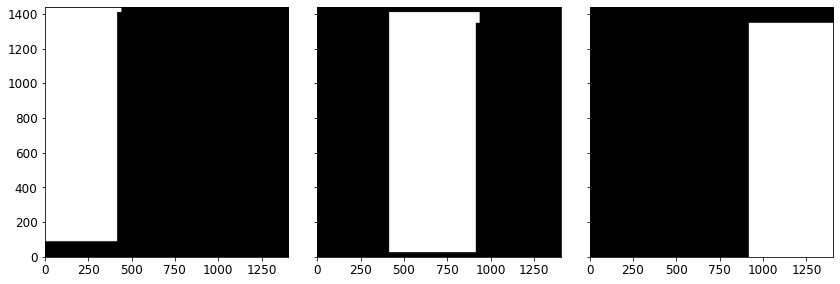

In [5]:
# For overlaping areas, IW2 is used when overlaped with IW1, IW3 is used when overlaped with IW2
# box in (x0, y0, x1, y1)
if 'SenAT099' in off_file:
    box1 = (0,   91,  440, 1439)  #v1 (0,   43, 211, 671)
    box2 = (406, 28,  936, 1411)  #v1 (195, 14, 449, 658) + 4
    box3 = (903,  0, 1403, 1349)  #v1 (433,  0, 673, 629) + 8

    mask1 = np.zeros((length, width), dtype=np.bool_)
    mask2 = np.zeros((length, width), dtype=np.bool_)
    mask3 = np.zeros((length, width), dtype=np.bool_)
    
    mask1[box1[1]:box1[3], box1[0]:box1[2]] = 1
    mask2[box2[1]:box2[3], box2[0]+9:box2[2]] = 1
    mask3[box3[1]:box3[3], box3[0]+11:box3[2]] = 1
    mask1[mask2==1] = 0
    mask2[mask3==1] = 0

elif 'SenDT106' in off_file:
    box1 = (0,     0,  416, 1340)
    box2 = (392,  90,  895, 1375)
    box3 = (870, 123, 1347, 1469)

    mask1 = np.zeros((length, width), dtype=np.bool_)
    mask2 = np.zeros((length, width), dtype=np.bool_)
    mask3 = np.zeros((length, width), dtype=np.bool_)
    
    mask1[box1[1]:box1[3], box1[0]:box1[2]] = 1
    mask2[box2[1]:box2[3], box2[0]:box2[2]] = 1
    mask3[box3[1]:box3[3], box3[0]:box3[2]] = 1
    mask1[mask2==1] = 0
    mask2[mask3==1] = 0

else:
    raise ValueError('un-recognized track!')

# write to file
atr['FILE_TYPE'] = 'mask'
atr['UNIT'] = '1'
writefile.write(mask1, out_file='maskIW1.h5', metadata=atr)
writefile.write(mask2, out_file='maskIW2.h5', metadata=atr)
writefile.write(mask3, out_file='maskIW3.h5', metadata=atr)

# plot
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=[12, 4], sharey=True)
for ax, mask in zip(axs, [mask1, mask2, mask3]):
    ax.imshow(mask, cmap='gray')
ax.invert_yaxis()
fig.tight_layout()
plt.show()

### 2.2 Estimate ramp for each sub-swath

Run `generate_mask.py azOff.h5 --roipoly --view-cmd "-v -0.1 0.1" -o maskAOI.h5` to create mask for the deforming area.

delete exsited file: rampIW1.h5
create HDF5 file: rampIW1.h5 with w mode
create dataset /offset of float32    in size of (1440, 1404)         with compression=None
finished writing to rampIW1.h5
delete exsited file: rampIW2.h5
create HDF5 file: rampIW2.h5 with w mode
create dataset /offset of float32    in size of (1440, 1404)         with compression=None
finished writing to rampIW2.h5
delete exsited file: rampIW3.h5
create HDF5 file: rampIW3.h5 with w mode
create dataset /offset of float32    in size of (1440, 1404)         with compression=None
finished writing to rampIW3.h5
delete exsited file: ramp.h5
create HDF5 file: ramp.h5 with w mode
create dataset /offset of float32    in size of (1440, 1404)         with compression=None
finished writing to ramp.h5
filtering offset file: ramp.h5 using lowpass_avg filter with kernel size of 15
delete exsited file: rampFilt.h5
create HDF5 file: rampFilt.h5 with w mode
create dataset /offset of float32    in size of (1440, 1404)         with c

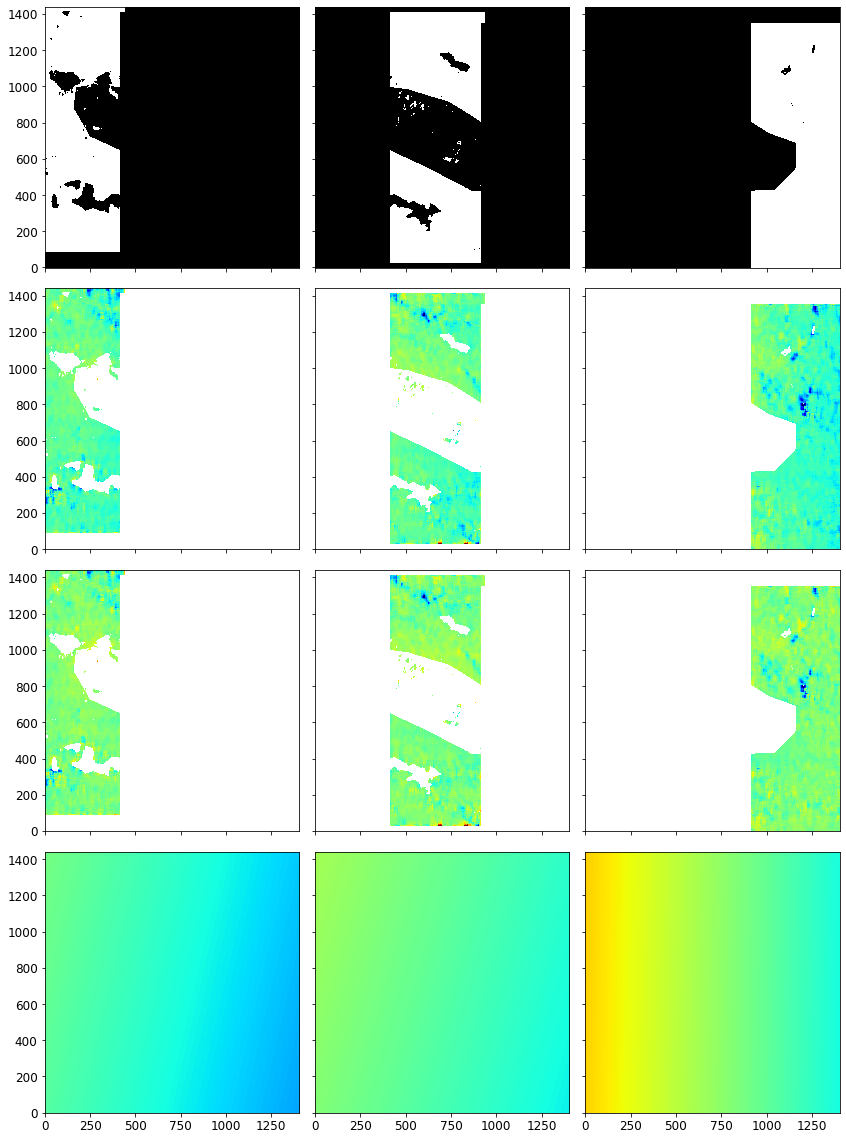

view.py rampFilt.h5 --noverbose -v -0.05 0.05 --save


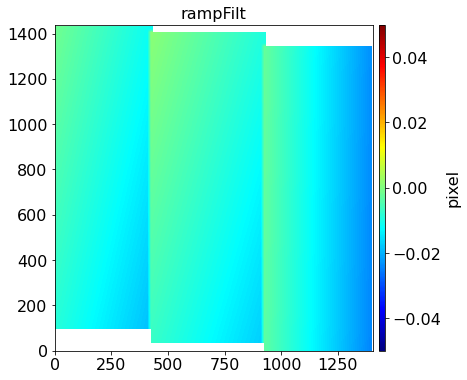

In [6]:
# mask offset for each sub-swath [in prep. for ramp estimation]
mask_aoi = readfile.read('maskAOI.h5')[0]
off = readfile.read('azOff.h5')[0]
for mask in [mask1, mask2, mask3]:
    mask[mask_aoi==1]   = 0
    mask[water_mask==0] = 0
    mask[np.isnan(off)] = 0
off1 = np.array(off, dtype=np.float32);  off1[mask1==0] = np.nan
off2 = np.array(off, dtype=np.float32);  off2[mask2==0] = np.nan
off3 = np.array(off, dtype=np.float32);  off3[mask3==0] = np.nan

# estimate ramps
off1_ramp, ramp1 = deramp(off1, ramp_type='linear', ignore_zero_value=False)
off2_ramp, ramp2 = deramp(off2, ramp_type='linear', ignore_zero_value=False)
off3_ramp, ramp3 = deramp(off3, ramp_type='linear', ignore_zero_value=False)

# write ramp files of each sub-swath
ramp_files = [f'rampIW{x}.h5' for x in [1,2,3]]
atr['FILE_TYPE'] = 'offset'
atr['UNIT'] = 'pixel'
for ramp, ramp_file in zip([ramp1, ramp2, ramp3], ramp_files):
    writefile.write(ramp, out_file=ramp_file, metadata=atr)

# merge the estimated ramp files for correction
ramp = np.zeros((length, width), dtype=np.float32) * np.nan
for x in [1,2,3]:
    maskIW = readfile.read(f'maskIW{x}.h5')[0]
    rampIW = readfile.read(f'rampIW{x}.h5')[0]
    ramp[maskIW] = rampIW[maskIW]
atr['FILE_TYPE'] = 'offset'
atr['UNIT'] = 'pixel'
writefile.write(ramp, out_file='ramp.h5', metadata=atr)

# filter the merged ramp: sub-swath overlap - mintpy low pass filter
spatial_filter.filter_file('ramp.h5', filter_type='lowpass_avg', filter_par=15, fname_out='rampFilt.h5')

# plot
kwargs = dict(cmap='jet', vmin=-0.1, vmax=0.1, interpolation='nearest')
fig, axs = plt.subplots(nrows=4, ncols=3, figsize=[12, 16], sharex=True, sharey=True)
for ax, mask in zip(axs[0,:], [mask1, mask2, mask3]):
    ax.imshow(mask, cmap='gray', interpolation='nearest')
for ax, data in zip(axs[1,:], [off1, off2, off3]):
    ax.imshow(data, **kwargs)
for ax, data in zip(axs[2,:], [off1_ramp, off2_ramp, off3_ramp]):
    ax.imshow(data, **kwargs)
for ax, data in zip(axs[3,:], [ramp1, ramp2, ramp3]):
    ax.imshow(data, **kwargs)
ax.invert_yaxis()
fig.tight_layout()
plt.show()

view.main(['rampFilt.h5', '--noverbose', '-v', '-0.05', '0.05', '--save'])

### 2.3 Correct ramps + conver to meter + masking

extract metadata from ISCE/topsStack xml file: /Users/yunjunz/data/archives/2021MaduoEQ/SenAT099/reference/IW1.xml
Azimuth pixel size on the ground: 14.06 m
offset min/max: -2.42 / 2.00 m
delete exsited file: azOffCor.h5
create HDF5 file: azOffCor.h5 with w mode
create dataset /displacement    of float32    in size of (1440, 1404)         with compression=None
create dataset /displacementStd of float32    in size of (1440, 1404)         with compression=None
add /displacement    attribute: UNIT = m
add /displacementStd attribute: UNIT = m
finished writing to azOffCor.h5
ascending orbit -> flip up-down
ascending orbit -> flip up-down


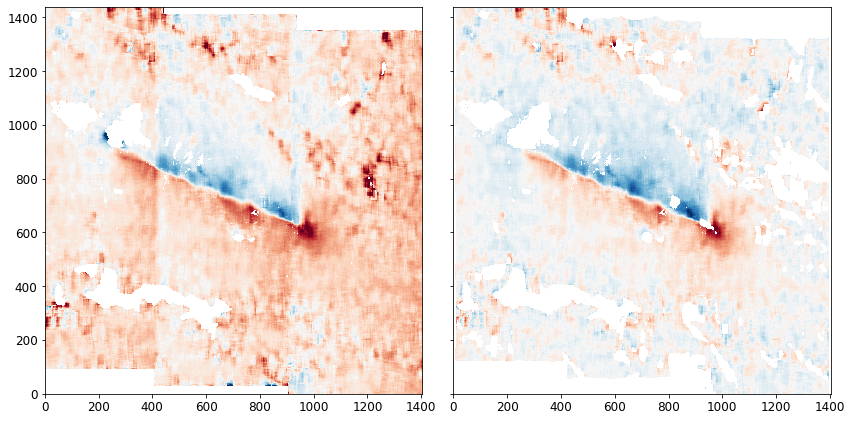

In [37]:
az_off_file = 'azOff.h5'
ramp_file = 'rampFilt.h5'

off, atr = readfile.read(az_off_file)
off_std = readfile.read(cov_file, datasetName='azimuthOffsetVar')[0] ** 0.5
off_std[np.isnan(off)] = np.nan

# 1. apply the ramp correction
ramp = readfile.read(ramp_file)[0]
off_cor = off - ramp

# 2. convert the unit from pixel to meters
xml_file = os.path.join(proj_dir, 'reference/IW1.xml')
meta = isce_utils.extract_isce_metadata(xml_file, update_mode=False)[0]
az_pixel_size = ut.azimuth_ground_resolution(meta)
print('Azimuth pixel size on the ground: {:.2f} m'.format(az_pixel_size))
off_cor *= az_pixel_size
off_std *= az_pixel_size
print('offset min/max: {:.2f} / {:.2f} m'.format(np.nanmin(off_cor), np.nanmax(off_cor)))

## 3. masking
# a. remote abnormal values
off_cor[np.abs(off_cor) > 2.5] = np.nan
# b. ignore zero value
off_cor[off_cor == 0] = np.nan
# c. ignore water body
off_cor[water_mask == 0] = np.nan
# d. skip pixels with SNR < 5
off_snr = readfile.read(snr_file)[0]
#off_cor[np.isnan(off_snr)] = np.nan
off_cor[off_snr < 3] = np.nan
# e. skip pixels with STD < 15 cm
off_cor[off_std > 0.15] = np.nan

# f. mask areas with artefacts 1 - SW of Eling Lake
if 'SenAT099' in off_file:
    x0, x1, y0, y1 = 200, 350, 910, 1040  #v1: 90, 155, 420, 460
    mask = np.zeros(off_cor.shape, dtype=np.bool_)
    mask[y0:y1, x0:x1][np.abs(off_cor[y0:y1, x0:x1]) > 0.02*az_pixel_size] = 1
    off_cor[mask==1] = np.nan

    # mask areas with artefacts 2 - Ma Qinggangri
    x0, x1, y0, y1 = 1160, 1320, 700, 900 #v1: 560, 610, 330, 420
    mask = np.zeros(off_cor.shape, dtype=np.bool_)
    mask[y0:y1, x0:x1][np.abs(off_cor[y0:y1, x0:x1]) > 0.025*az_pixel_size] = 1
    off_cor[mask==1] = np.nan

    # mask areas with artefacts 3 - sub-swath boundary
    x0, x1, y0, y1 = 400, 920, 0, 60  #v1: 190, 440, 0, 25
    mask = np.zeros(off_cor.shape, dtype=np.bool_)
    mask[y0:y1, x0:x1][np.abs(off_cor[y0:y1, x0:x1]) > 0.05*az_pixel_size] = 1
    off_cor[mask==1] = np.nan

# write file
az_off_cor_file = 'azOffCor.h5'
ds_dict = {'displacement' : np.array(off_cor, dtype=np.float32), 'displacementStd' : np.array(off_std, dtype=np.float32)}
ds_unit_dict = {'displacement' : 'm', 'displacementStd' : 'm'}
atr['UNIT'] = 'm'
writefile.write(ds_dict, out_file=az_off_cor_file, metadata=atr, ds_unit_dict=ds_unit_dict)

# plot
kwargs = dict(cmap='RdBu', vmin=-1, vmax=1, interpolation='nearest')
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=[12, 6], sharey=True)
for ax, data in zip(axs, [off*az_pixel_size, off_cor]):
    ax.imshow(data, **kwargs)
    pp.auto_flip_direction(atr, ax)
fig.tight_layout()
plt.show()

### 2.4 Filter

In [35]:
if 'SenDT106' in off_file:
    print('fill holes with smoothed values ...')
    filter_size = 75
    off_fill = fill_offset_rubber_sheeting(off_cor, filter_size, print_msg=True)
    print('apply a median filter ...')
    off_filt = ndimage.median_filter(off_fill, filter_size)
    off_filt[np.isnan(off_cor)] = np.nan

    # write to file
    ds_dict = {
        'displacement'    : np.array(off_filt * az_pixel_size, dtype=np.float32),
        'displacementStd' : np.array(off_std * az_pixel_size, dtype=np.float32),
    }
    ds_unit_dict = {
        'displacement'    : 'm',
        'displacementStd' : 'm',
    }
    out_file = 'azOffCorFilt.h5'
    writefile.write(ds_dict, out_file, metadata=atr, ds_unit_dict=ds_unit_dict)

    # plot
    kwargs = dict(cmap='RdBu', vmin=-0.1, vmax=0.1, interpolation='nearest')
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=[12, 6], sharey=True)
    for ax, data in zip(axs, [off_cor, off_filt]):
        ax.imshow(data, **kwargs)
        pp.auto_flip_direction(atr, ax)
    fig.tight_layout()
    plt.show()

else:
    print('The ascending track is good enough without filter, skip it.')

The ascending track is good enough without filter, skip it.


## 3. Geocode [to ISCE-2 format]

No lookup table info range/lat found in files.
number of processor to be used: 1
resampling software: pyresample
read latitude / longitude from lookup table file: /Users/yunjunz/data/archives/2021MaduoEQ/SenAT099/merged/offsets/20210520_20210526/geom5/lat.rdr
output pixel size in (lat, lon) in degree: (-0.001111112, 0.001111112)
output area extent in (S, N, W, E) in degree: (33.19999784, 35.9, 96.6, 100.1000028)
output file row / column number: (2430, 3150)
searching relevant box covering the current SNWE
--------------------------------------------------
resampling file: azOffCor.h5
--------------------------------------------------
reading displacement in block (0, 0, 1403, 1439) from azOffCor.h5 ...
nearest resampling with pyresample.kd_tree using 1 CPU cores in 9 segments ...
write file: azOffCor.geo
write file: azOffCor.geo.rsc
write file: azOffCor.geo.xml
write file: azOffCor.geo.vrt
time used: 00 mins 3.9 secs.

run view.py in MintPy version v1.3.2-29, date 2022-02-03
input file

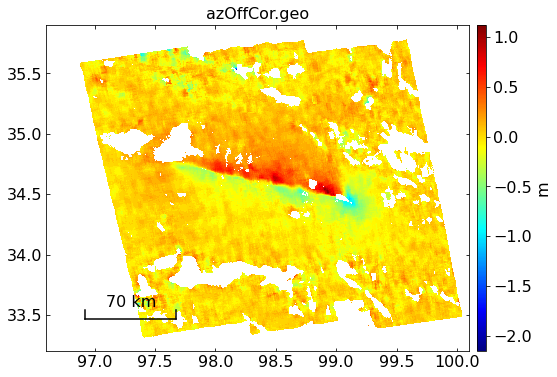

No lookup table info range/lat found in files.
number of processor to be used: 1
resampling software: pyresample
read latitude / longitude from lookup table file: /Users/yunjunz/data/archives/2021MaduoEQ/SenAT099/merged/offsets/20210520_20210526/geom5/lat.rdr
output pixel size in (lat, lon) in degree: (-0.001111112, 0.001111112)
output area extent in (S, N, W, E) in degree: (33.19999784, 35.9, 96.6, 100.1000028)
output file row / column number: (2430, 3150)
searching relevant box covering the current SNWE
--------------------------------------------------
resampling file: azOffCor.h5
--------------------------------------------------
reading displacementStd in block (0, 0, 1403, 1439) from azOffCor.h5 ...
nearest resampling with pyresample.kd_tree using 1 CPU cores in 9 segments ...
write file: azOffCorStd.geo
write file: azOffCorStd.geo.rsc
write file: azOffCorStd.geo.xml
write file: azOffCorStd.geo.vrt
time used: 00 mins 3.8 secs.

No lookup table info range/lat found in files.
numbe

In [40]:
src_file = [x for x in ['azOffCorFilt.h5', 'azOffCor.h5'] if os.path.isfile(x)][0]
S, N, W, E = SNWE
step = 0.001111112  # deg for 120 m
opt = f' --bbox {S} {N} {W} {E} --lalo -{step} {step} --lat-file {lat_file} --lon-file {lon_file}'

geo_file = '{}.geo'.format(os.path.splitext(src_file)[0])
cmd = f'{src_file} --dset displacement -o {geo_file} {opt}'
geocode.main(cmd.split())
view.main([f'{geo_file}'])

out_file = '{}Std.geo'.format(os.path.splitext(src_file)[0])
cmd = f'{src_file} --dset displacementStd -o {out_file} {opt}'
geocode.main(cmd.split())

out_file = '{}.geo'.format(os.path.splitext(los_file)[0])
cmd = f'{los_file} -o {out_file} {opt}'
geocode.main(cmd.split())

## 4. Plot

run view.py in MintPy version v1.3.2-29, date 2022-02-03
input file is isce offset file: /Users/yunjunz/data/archives/2021MaduoEQ/SenAT099/merged/offsets/20210520_20210526/azOffCor.geo in float32 format
file size in y/x: (2430, 3150)
num of datasets in file azOffCor.geo: 1
datasets to exclude (0):
[]
datasets to display (1):
['band1']
data   coverage in y/x: (0, 0, 3150, 2430)
subset coverage in y/x: (0, 0, 3150, 2430)
data   coverage in lat/lon: (96.6, 35.9, 100.1000028, 33.19999784)
subset coverage in lat/lon: (96.6, 35.9, 100.1000028, 33.19999784)
------------------------------------------------------------------------
area exceed 2000 pixels, turn off default DEM contour display
colormap: RdBu
initiate cartopy map projection: PlateCarree
figure title: azOffCor.geo
figure size : [9.72, 6.00]
reading data ...
data    range: [-2.1517756, 1.1171442] m
display range: [-1.0, 1.0] m
reading DEM: demLat_N33_N36_Lon_E096_E101.dem ...
display data in transparency: 0.8
plot in geo-coordinate


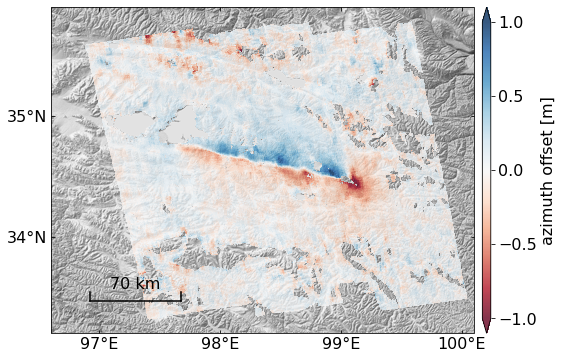

In [42]:
cmd = f'{geo_file} --dem {dem_file} -v -1 1 -c RdBu --notitle '
cmd += ' --notitle --lalo-label --cbar-nbins 5 --save'
view.main(cmd.split() + ['--cbar-label', 'azimuth offset [m]'])

## 5. Supplementary Figure: Compare azimuth offsets w/o and w/ extra processing

In [2]:
# utils
def read_az_offset(off_file):
    # aux files
    fbase = os.path.splitext(off_file)[0]
    cov_file = fbase + '_cov.bip'
    snr_file = fbase + '_snr.bip'
    geom_dir = os.path.join(os.path.dirname(off_file), 'geom{}'.format(off_file[-5]))
    msk_file = os.path.join(geom_dir, 'waterMask.rdr')

    # read offset
    off, atr = readfile.read(off_file, datasetName='azimuthOffset')

    # mask 1 - water mask, valid mask from SNR and/or mask based on STD
    water_mask = readfile.read(msk_file)[0]
    off[water_mask==0] = np.nan

    # mask 2 - valid region from SNR no-data value
    off_snr = readfile.read(snr_file)[0]
    off[np.isnan(off_snr)] = np.nan

    # mask 3 - offset STD
    #off_std = np.sqrt(readfile.read(cov_file, datasetName='azimuthOffsetVar')[0])
    #off[off_std > 0.01] = np.nan

    # remove an median offset
    off -= np.nanmedian(off)
    
    # unit: pixel to meter
    proj_dir = os.path.abspath(os.path.join(off_file, '../../../..'))
    xml_file = os.path.join(proj_dir, 'reference/IW1.xml')
    meta = isce_utils.extract_isce_metadata(xml_file, update_mode=False)[0]
    az_pixel_size = ut.azimuth_ground_resolution(meta)
    off *= az_pixel_size

    return off, atr
print('Utilities function initiated.')

Utilities function initiated.


extract metadata from ISCE/topsStack xml file: /Users/yunjunz/data/archives/2021MaduoEQ/SenDT106/reference/IW1.xml
This is the Open Source version of ISCE.
Some of the workflows depend on a separate licensed package.
To obtain the licensed package, please make a request for ISCE
through the website: https://download.jpl.nasa.gov/ops/request/index.cfm.
Alternatively, if you are a member, or can become a member of WinSAR
you may be able to obtain access to a version of the licensed sofware at
https://winsar.unavco.org/software/isce
descending orbit -> flip left-right
descending orbit -> flip left-right
save figure to file /Users/yunjunz/data/archives/2021MaduoEQ/SenDT106/merged/offsets/20210520_20210526/az_off_comp.png


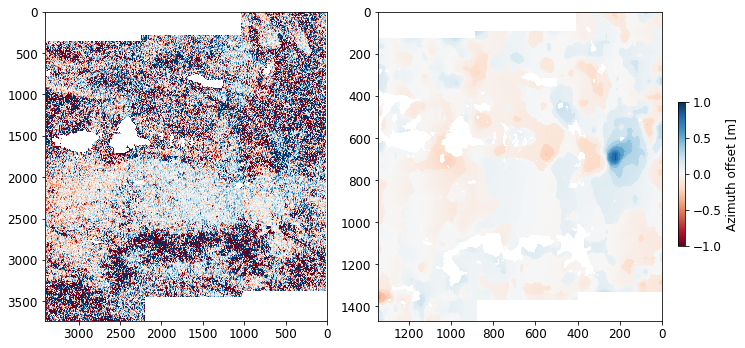

In [3]:
# input dataset for SenAT099
#off_file1 = os.path.expanduser('~/data/archives/2021MaduoEQ/SenAT099/merged/offsets/20210520_20210526/offset1.bip')
#off_file2 = os.path.expanduser('~/data/archives/2021MaduoEQ/SenAT099/merged/offsets/20210520_20210526/azOffCor.h5')
## input dataset for SenDT106
off_file1 = os.path.expanduser('~/data/archives/2021MaduoEQ/SenDT106/merged/offsets/20210520_20210526/offset3.bip')
off_file2 = os.path.expanduser('~/data/archives/2021MaduoEQ/SenDT106/merged/offsets/20210520_20210526/azOffCorFilt.h5')

# read data
off1, atr = read_az_offset(off_file1)
off2, atr = readfile.read(off_file2)

# plot
kwargs = dict(cmap='RdBu', vmin=-1, vmax=1, interpolation='nearest')
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=[10, 5])
for ax, data in zip(axs, [off1, off2]):
    im = ax.imshow(data, **kwargs)
    pp.auto_flip_direction(atr, ax)
fig.tight_layout()

# colorbar
fig.subplots_adjust(right=0.93)
cax = fig.add_axes([0.95, 0.3, 0.01, 0.4])
cbar = plt.colorbar(im, cax=cax, orientation='vertical')
cbar.set_label('Azimuth offset [m]')

# output
out_fig = os.path.join(os.path.dirname(off_file1), 'az_off_comp.png')
print('save figure to file', out_fig)
plt.savefig(out_fig, bbox_inches='tight', transparent=True, dpi=300)
plt.show()